In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings(action='ignore')

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
img_dir = Path('../input/dockship-boat-type-classification/Train')

In [3]:
# create list
img_files = list(img_dir.glob(r'**/*.jpg'))
img_files

[PosixPath('../input/dockship-boat-type-classification/Train/freight_boat/20.jpg'),
 PosixPath('../input/dockship-boat-type-classification/Train/freight_boat/6.jpg'),
 PosixPath('../input/dockship-boat-type-classification/Train/freight_boat/5.jpg'),
 PosixPath('../input/dockship-boat-type-classification/Train/freight_boat/8.jpg'),
 PosixPath('../input/dockship-boat-type-classification/Train/freight_boat/10.jpg'),
 PosixPath('../input/dockship-boat-type-classification/Train/freight_boat/9.jpg'),
 PosixPath('../input/dockship-boat-type-classification/Train/freight_boat/1.jpg'),
 PosixPath('../input/dockship-boat-type-classification/Train/freight_boat/16.jpg'),
 PosixPath('../input/dockship-boat-type-classification/Train/freight_boat/23.jpg'),
 PosixPath('../input/dockship-boat-type-classification/Train/freight_boat/7.jpg'),
 PosixPath('../input/dockship-boat-type-classification/Train/freight_boat/22.jpg'),
 PosixPath('../input/dockship-boat-type-classification/Train/freight_boat/13.jpg')

In [4]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], img_files ))

In [5]:
img_df = pd.DataFrame({'Filepath': img_files, 'label':labels}).astype(str).sample(frac = 1.0, random_state=1).reset_index(drop = True)
img_df

,Filepath,label
0,../input/dockship-boat-type-classification/Tra...,sailboat
1,../input/dockship-boat-type-classification/Tra...,gondola
2,../input/dockship-boat-type-classification/Tra...,cruise_ship
3,../input/dockship-boat-type-classification/Tra...,cruise_ship
4,../input/dockship-boat-type-classification/Tra...,kayak
...,...,...
1157,../input/dockship-boat-type-classification/Tra...,cruise_ship
1158,../input/dockship-boat-type-classification/Tra...,sailboat
1159,../input/dockship-boat-type-classification/Tra...,sailboat
1160,../input/dockship-boat-type-classification/Tra...,paper_boat


In [6]:
img_df['label'].value_counts()

sailboat           389
kayak              203
gondola            193
cruise_ship        191
ferry_boat          63
buoy                53
paper_boat          31
freight_boat        23
inflatable_boat     16
Name: label, dtype: int64

In [7]:
train_df,test_df = train_test_split(img_df, train_size =0.7, shuffle= True, random_state = 1)

load image data 

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255, # pixel between 0 and 1 
    validation_split=0.2
)

test_generator =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

In [9]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 651 validated image filenames belonging to 9 classes.


In [10]:
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 162 validated image filenames belonging to 9 classes.


In [11]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 349 validated image filenames belonging to 9 classes.


training 

In [12]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x) # pool after each layer
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)  # avg first 2 layers
x = tf.keras.layers.Dense(128, activation='relu')(x) # classificaiton 
x = tf.keras.layers.Dense(128, activation='relu')(x)

In [13]:
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)# all 9 sum to 1

In [14]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # image data gen, have to use this instead of sparse since data can have multi class due to 1 hot encoding; sparse better w ints
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
21/21 [==============================] - 33s 2s/step - loss: 2.0670 - accuracy: 0.2276 - val_loss: 1.8145 - val_accuracy: 0.3210
Epoch 2/100
21/21 [==============================] - 29s 1s/step - loss: 1.8451 - accuracy: 0.3145 - val_loss: 1.7859 - val_accuracy: 0.3210
Epoch 3/100
21/21 [==============================] - 29s 1s/step - loss: 1.7593 - accuracy: 0.3281 - val_loss: 1.7935 - val_accuracy: 0.3210
Epoch 4/100
21/21 [==============================] - 29s 1s/step - loss: 1.7866 - accuracy: 0.3358 - val_loss: 1.7847 - val_accuracy: 0.3210
Epoch 5/100
21/21 [==============================] - 29s 1s/step - loss: 1.7790 - accuracy: 0.3364 - val_loss: 1.7660 - val_accuracy: 0.3210
Epoch 6/100
21/21 [==============================] - 29s 1s/step - loss: 1.7638 - accuracy: 0.3378 - val_loss: 1.7550 - val_accuracy: 0.3210
Epoch 7/100
21/21 [==============================] - 29s 1s/step - loss: 1.8047 - accuracy: 0.3125 - val_loss: 1.7296 - val_accuracy: 0.3025
Epoch 8/100
2

results

In [16]:
result =  model.evaluate(test_images, verbose = 0)

print('test loss: {:.5f}'.format(result[0]))
print('test accuracy: {:.2f}%'.format(result[1])*100)

test loss: 1.52898
test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%test accuracy: 0.51%t

In [17]:
pred = np.argmax(model.predict(test_images),axis=1)
pred

array([6, 1, 8, 1, 1, 1, 8, 6, 8, 8, 8, 1, 8, 6, 1, 8, 8, 8, 6, 1, 1, 1,
       8, 8, 8, 8, 8, 4, 1, 4, 8, 8, 1, 8, 8, 6, 8, 6, 6, 1, 8, 4, 4, 4,
       4, 8, 6, 8, 6, 4, 6, 6, 8, 8, 6, 8, 6, 8, 8, 4, 8, 8, 8, 8, 8, 8,
       8, 6, 6, 6, 1, 6, 4, 8, 4, 8, 8, 8, 8, 8, 1, 8, 6, 6, 8, 8, 8, 1,
       1, 8, 8, 8, 6, 6, 4, 6, 6, 6, 4, 6, 6, 1, 8, 1, 8, 8, 4, 4, 8, 8,
       6, 8, 8, 8, 6, 6, 8, 1, 6, 1, 8, 4, 1, 6, 6, 6, 8, 8, 6, 6, 8, 8,
       8, 8, 6, 6, 6, 6, 6, 4, 4, 6, 1, 8, 6, 4, 8, 6, 1, 6, 6, 4, 8, 6,
       6, 4, 8, 8, 4, 6, 8, 8, 4, 6, 1, 8, 6, 8, 8, 1, 8, 1, 8, 4, 6, 6,
       8, 8, 8, 8, 6, 8, 8, 1, 4, 1, 6, 8, 8, 8, 8, 8, 8, 6, 8, 6, 1, 6,
       6, 1, 6, 1, 6, 4, 6, 4, 4, 6, 8, 8, 6, 6, 4, 1, 8, 8, 6, 8, 4, 8,
       8, 8, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 4, 6, 8, 6, 6, 8, 4, 1, 8,
       4, 1, 1, 6, 6, 6, 8, 4, 8, 6, 6, 8, 8, 4, 6, 1, 8, 8, 6, 6, 6, 4,
       4, 6, 6, 8, 8, 6, 6, 8, 6, 4, 6, 6, 4, 4, 6, 6, 1, 6, 8, 1, 8, 8,
       8, 4, 1, 4, 8, 8, 6, 6, 8, 1, 6, 8, 6, 6, 8,

In [18]:
(train_images.class_indices)

{'buoy': 0,
 'cruise_ship': 1,
 'ferry_boat': 2,
 'freight_boat': 3,
 'gondola': 4,
 'inflatable_boat': 5,
 'kayak': 6,
 'paper_boat': 7,
 'sailboat': 8}

In [19]:
cm = confusion_matrix(test_images.labels,pred)
clr = classification_report(test_images.labels,pred, target_names = list(train_images.class_indices.keys())  )

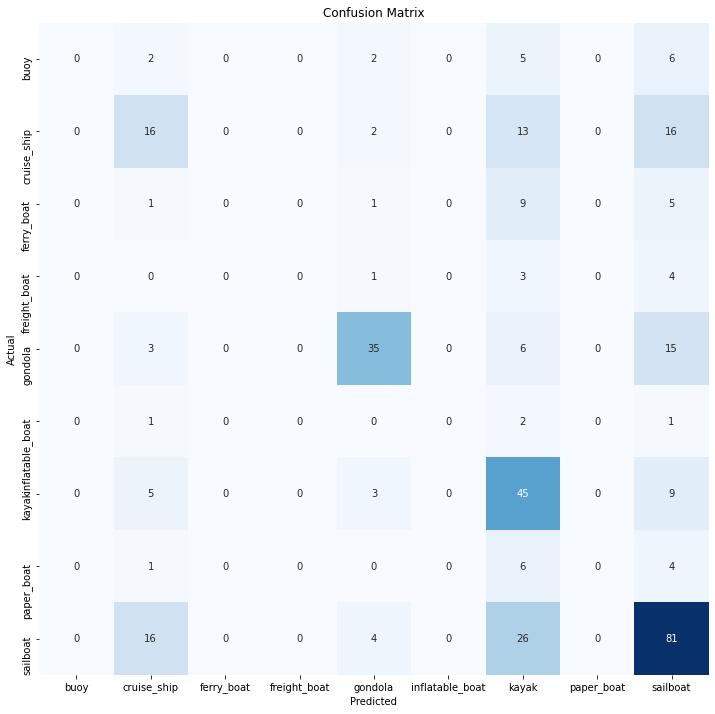

Classification Report:
----------------------
                  precision    recall  f1-score   support

           buoy       0.00      0.00      0.00        15
    cruise_ship       0.36      0.34      0.35        47
     ferry_boat       0.00      0.00      0.00        16
   freight_boat       0.00      0.00      0.00         8
        gondola       0.73      0.59      0.65        59
inflatable_boat       0.00      0.00      0.00         4
          kayak       0.39      0.73      0.51        62
     paper_boat       0.00      0.00      0.00        11
       sailboat       0.57      0.64      0.60       127

       accuracy                           0.51       349
      macro avg       0.23      0.26      0.23       349
   weighted avg       0.45      0.51      0.47       349



In [20]:
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(9) + 0.5, labels=list(train_images.class_indices.keys()))
plt.yticks(ticks=np.arange(9) + 0.5, labels=list(train_images.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)
